# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Traitement Naturel du Langage (NLP) : Catégorisation de Produits Cdiscount

Il s'agit d'une version simplifiée du concours proposé par Cdiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge). Les données d'apprentissage sont accessibles sur demande auprès de Cdiscount mais les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif (*text mining*). Seule la catégorie principale (1er niveau, 47 classes) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. 

Le jeux de données complet (15M produits) permet un test en vrai grandeur du **passage à l'échelle volume** des phases de préparation (*munging*), vectorisation (hashage, TF-IDF) et d'apprentissage en fonction de la technologie utilisée.

La synthèse des résultats obtenus est développée par [Besse et al. 2016](https://hal.archives-ouvertes.fr/hal-01350099) (section 5).

## Partie 1-3 : Modèle d'apprentissage statistiques.

Dans le calepin numéro 2, nous avons créés 2x7 matrices de features correspondant au mêmes échantillons d'apprentissage et de validation des données textuelles de description d'objet de Cdiscount.  Ces matrices ont été crées avec les méthodes suivantes. 

1. `Count_Vectorizer`. `No hashing`.
2. `Count_Vectorizer`. `Hashing = 300`.
3. `TFIDF_vectorizer`. `No hashing`. 
4. `TFIDF_vectorizer`. `Hashing = 300`.
5. `Word2Vec`. `CBOW`
6. `Word2Vec`. `Skip-Gram`
7. `Word2Vec`. `Pre-trained`

Nous allons maintenant étudiés les performances d'algorithmes de *machine learning* (`Regression logistique`, `Forêts aléatoire`, `Perceptron multicouche`) sur ces différents features 

## Librairies

In [1]:
#Importation des librairies utilisées
import time
import numpy as np
import pandas as pd
import scipy as sc
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

DATA_DIR = "data/features"

## Téléchargement des données

Téléchargement des variables réponses

In [2]:
Y_train = pd.read_csv("data/cdiscount_train_subset.csv").fillna("")["Categorie1"]
Y_valid = pd.read_csv("data/cdiscount_valid.csv").fillna("")["Categorie1"]

Création d'un dictionnaire contenant les chemins ou des différents objets où sont stockés les matrices de features.

In [3]:
features_path_dic = {}

parameters = [["count_no_hashing", None, "count"],
              ["count_300", 300, "count"],
              ["tfidf_no_hashing", None, "tfidf"],
              ["tfidf_300",300, "tfidf"]]
for name, nb_hash, vectorizer in parameters:
        x_train_path = DATA_DIR +"/vec_train_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz"
        x_valid_path = DATA_DIR +"/vec_valid_nb_hash_" + str(nb_hash) + "_vectorizer_" + str(vectorizer)+".npz"
        dic = {"x_train_path" : x_train_path, "x_valid_path" : x_valid_path, "load" : "npz"}
        features_path_dic.update({name : dic})
 
parametersw2v = [["word2vec_cbow","cbow"],
                 ["word2vec_sg","sg"],
                 ["word2vec_online","online"]]
for name, mtype in parametersw2v:
        x_train_path = DATA_DIR +"/embedded_train_" + mtype+".npy"
        x_valid_path = DATA_DIR +"/embedded_valid_" + mtype+".npy"
        dic = {"x_train_path" : x_train_path, "x_valid_path" : x_valid_path, "load" : "npy"}
        features_path_dic.update({name : dic})

# Regression Logistique

## Apprentissage

Le code suivant peut être très long. Vous pouvez dans un premier temps exécutez directement la cellule suivante ou les résultats de l'execution de cette cellules sont disponibles. 

In [ ]:
metadata_list_lr = []

param_grid = {"C" : [10,1,0.1]}
#param_grid = {"C" : [1]}

for name, dic in features_path_dic.items():
    
    x_train_path = dic["x_train_path"]
    x_valid_path = dic["x_valid_path"]
    load = dic["load"]
    
    print("Load features : " + name)
    if load == "npz":
        X_train = sc.sparse.load_npz(x_train_path)
        X_valid = sc.sparse.load_npz(x_valid_path)
    else : 
        X_train = np.load(x_train_path)
        X_valid = np.load(x_valid_path)
    
    print("start Learning :" + name)
    ts = time.time()
    gs = GridSearchCV(LogisticRegression(), param_grid=param_grid, verbose=15)
    gs.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    
    print("start prediction :" + name)
    ts = time.time()
    score_train=gs.score(X_train,Y_train)
    score_valid=gs.score(X_valid,Y_valid)
    te=time.time()
    t_predict = te-ts
    
    metadata = {"name":name, "learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_valid": score_valid}
    metadata_list_lr.append(metadata)
pickle.dump(metadata_list_lr, open("data/metadata_lr_part13.pkl","wb"))       

## Exploitation des résultats

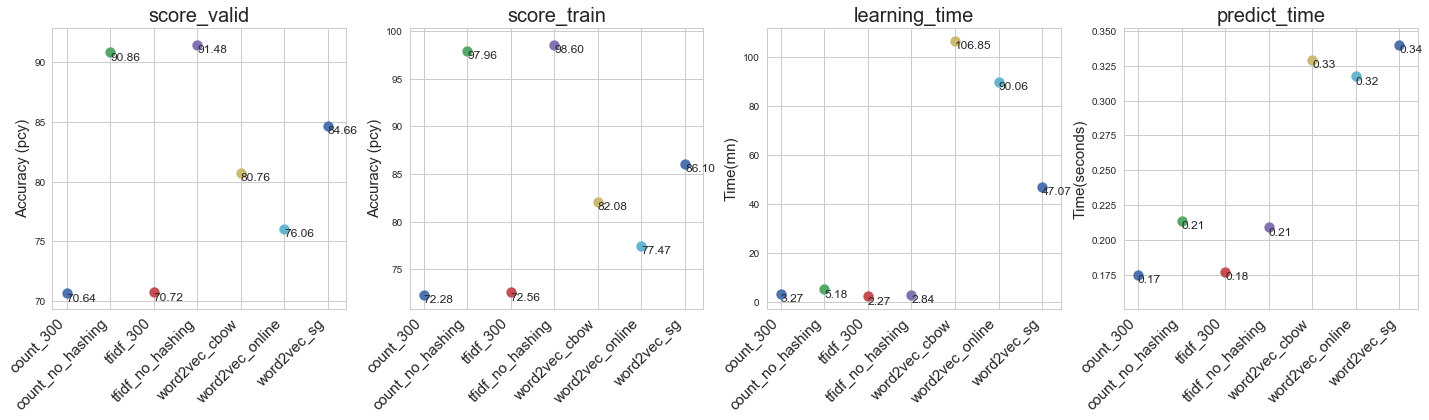

In [4]:
metadata_list_lr = pickle.load(open("data/metadata_lr_part13.pkl","rb"))       
metadata_list_lr_sorted = sorted(metadata_list_lr, key = lambda x : x["name"])
xlabelticks = [metadata["name"] for metadata in metadata_list_lr_sorted]

fig = plt.figure(figsize=(20,6))
key_plot = [key for key in metadata_list_lr[0].keys() if key !="name"]
for iplot, key in enumerate(key_plot):
    ax = fig.add_subplot(1,4,iplot+1)
    for i,metadata in enumerate(metadata_list_lr_sorted):
        if key=="learning_time":
            scale=60
            ylabel="Time(mn)"
        elif key=="predict_time":
            scale=1
            ylabel="Time(seconds)"
        else:
            scale=0.01
            ylabel = 'Accuracy (pcy)'
            
        ax.scatter(i,metadata[key]/scale, s=100)
        ax.text(i,metadata[key]/scale,"%.2f"%(metadata[key]/scale), ha="left", va="top")
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(xlabelticks, rotation=45, fontsize=15, ha="right")
    ax.set_title(key, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=15)
plt.tight_layout()
plt.show()

**Q** Comment expliquer le long de temps d'apprentissage de la regression logistique sur les modèles issues de Word2Vec?

**Q** Comment expliquer la différence de qualité d'apprentissage en fonction du hashing ?


# Random Forest

In [5]:
metadata_list_rf = []

param_grid = {"n_estimators" : [100,500]}

for name, dic in features_path_dic.items():
    
    x_train_path = dic["x_train_path"]
    x_valid_path = dic["x_valid_path"]
    load = dic["load"]
    
    print("Load features : " + name)
    if load == "npz":
        X_train = sc.sparse.load_npz(x_train_path)
        X_valid = sc.sparse.load_npz(x_valid_path)
    else : 
        X_train = np.load(x_train_path)
        X_valid = np.load(x_valid_path)
    
    print("start Learning :" + name)
    ts = time.time()
    gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=15)
    gs.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    
    print("start prediction :" + name)
    ts = time.time()
    score_train=gs.score(X_train,Y_train)
    score_valid=gs.score(X_valid,Y_valid)
    te=time.time()
    t_predict = te-ts
    
    metadata = {"name":name, "learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_valid": score_valid}
    metadata_list_rf.append(metadata)
pickle.dump(metadata_list_rf, open("data/metadata_rf_part13.pkl","wb"))   

Load features : word2vec_sg
start Learning :word2vec_sg
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=100, score=0.846675926510512, total= 3.5min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8470792548152826, total= 3.4min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8489510931378744, total= 3.3min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8495170149630659, total=16.7min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.3min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8514998421218819, total=16.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 44.4min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.8526159484392771, total=16.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 61.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 61.0min finished


start prediction :word2vec_sg
Load features : count_300
start Learning :count_300
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.7635267377991035, total= 2.5min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7604041679823177, total= 2.5min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7637748009604448, total= 2.5min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.7min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7658311762106194, total=12.3min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 20.4min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7629617934954215, total=12.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.2min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.7671869076203716, total=12.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 46.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 46.1min finished


start prediction :count_300
Load features : count_no_hashing
start Learning :count_no_hashing
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.8359744933392259, total= 7.0min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8347963372276602, total= 7.0min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.3min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8403260457475041, total= 7.0min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.5min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8398888818738557, total=34.9min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 57.3min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8390274707925481, total=34.9min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 93.1min remaining:    0.0s


[CV] ........ n_estimators=500, score=0.842442815619866, total=34.9min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 128.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 128.9min finished


start prediction :count_no_hashing
Load features : tfidf_300
start Learning :tfidf_300
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.7641896584380327, total= 2.6min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7656772971266183, total= 2.6min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7682926829268293, total= 2.6min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.0min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7674411263337332, total=12.9min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.4min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7677297126618251, total=12.9min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.8min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7704094527991912, total=13.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 48.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 48.2min finished


start prediction :tfidf_300
Load features : word2vec_online
start Learning :word2vec_online
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.7279184291937623, total= 3.0min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7292706030944112, total= 3.0min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.7302224188044989, total= 3.0min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.2min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.7353683944693478, total=15.0min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.5min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.7364698452794443, total=15.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 39.9min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.7364463541008467, total=14.9min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 55.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 55.1min finished


start prediction :word2vec_online
Load features : word2vec_cbow
start Learning :word2vec_cbow
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.8175074183976261, total= 3.4min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8188190716766656, total= 3.4min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.9min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8217806141791988, total= 3.3min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8224319717153861, total=16.9min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.4min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.8233659614777392, total=16.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 44.5min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.8249399721976495, total=16.7min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 61.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 61.4min finished


start prediction :word2vec_cbow
Load features : tfidf_no_hashing
start Learning :tfidf_no_hashing
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.8414356966980239, total= 6.5min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8392800757814967, total= 6.6min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.5min remaining:    0.0s


[CV] ....... n_estimators=100, score=0.8432326551244788, total= 6.5min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.2min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8439926763053223, total=32.6min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 53.7min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.8426270918850647, total=32.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 87.4min remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=500, score=0.8467079489447744, total=32.7min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 121.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 121.1min finished


start prediction :tfidf_no_hashing


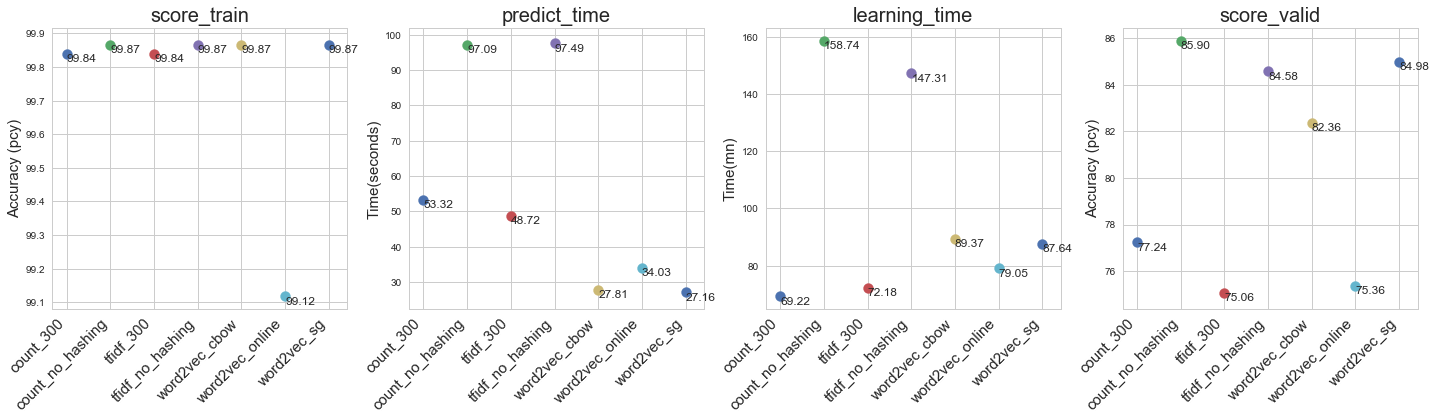

In [8]:
metadata_list_rf = pickle.load(open("data/metadata_rf_part13.pkl","rb"))       
metadata_list_rf_sorted = sorted(metadata_list_rf, key = lambda x : x["name"])
xlabelticks = [metadata["name"] for metadata in metadata_list_rf_sorted]

fig = plt.figure(figsize=(20,6))
key_plot = [key for key in metadata_list_rf[0].keys() if key !="name"]
for iplot, key in enumerate(key_plot):
    ax = fig.add_subplot(1,4,iplot+1)
    for i,metadata in enumerate(metadata_list_rf_sorted):
        if key=="learning_time":
            scale=60
            ylabel="Time(mn)"
        elif key=="predict_time":
            scale=1
            ylabel="Time(seconds)"
        else:
            scale=0.01
            ylabel = 'Accuracy (pcy)'
            
        ax.scatter(i,metadata[key]/scale, s=100)
        ax.text(i,metadata[key]/scale,"%.2f"%(metadata[key]/scale), ha="left", va="top")
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(xlabelticks, rotation=45, fontsize=15, ha="right")
    ax.set_title(key, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=15)
plt.tight_layout()
plt.show()

# 5 MLP

In [9]:
metadata_list_mlp = []

param_grid = {"hidden_layer_sizes" : [32,64,128, 256]}

for name, dic in features_path_dic.items():
    
    x_train_path = dic["x_train_path"]
    x_valid_path = dic["x_valid_path"]
    load = dic["load"]
    
    print("Load features : " + name)
    if load == "npz":
        X_train = sc.sparse.load_npz(x_train_path)
        X_valid = sc.sparse.load_npz(x_valid_path)
    else : 
        X_train = np.load(x_train_path)
        X_valid = np.load(x_valid_path)
    
    print("start Learning :" + name)
    ts = time.time()
    gs = GridSearchCV(MLPClassifier(learning_rate = "adaptive", ), param_grid=param_grid, verbose=15)
    gs.fit(X_train,Y_train.values)
    te=time.time()
    t_learning = te-ts
    
    print("start prediction :" + name)
    ts = time.time()
    score_train=gs.score(X_train,Y_train)
    score_valid=gs.score(X_valid,Y_valid)
    te=time.time()
    t_predict = te-ts
    
    metadata = {"name":name, "learning_time" : t_learning, "predict_time":t_predict, "score_train": score_train, "score_valid": score_valid}
    metadata_list_mlp.append(metadata)
pickle.dump(metadata_list_mlp, open("data/metadata_mlp_part13.pkl","wb")) 

Load features : word2vec_sg
start Learning :word2vec_sg
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................
[CV] .. hidden_layer_sizes=32, score=0.8574089273312709, total= 1.4min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ... hidden_layer_sizes=32, score=0.857246605620461, total= 2.1min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8565019588019714, total= 2.8min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.8648904602563293, total= 3.4min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.7min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8656141458793811, total= 2.2min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.8min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.8683811449513459, total= 4.6min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.4min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.8655533808952586, total= 6.1min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 22.6min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.8643511209346385, total= 5.0min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.6min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.8684443321117149, total= 4.1min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 31.8min remaining:    0.0s


[CV] .. hidden_layer_sizes=256, score=0.867573710461519, total=12.1min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 43.9min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.8664666877170825, total=13.6min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 57.6min remaining:    0.0s


[CV] .. hidden_layer_sizes=256, score=0.868823455073929, total=12.1min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 69.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 69.8min finished
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


start prediction :word2vec_sg
Load features : count_300
start Learning :count_300
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................


/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=32, score=0.7176589431150957, total= 1.3min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.7205557309756868, total= 1.1min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV] ... hidden_layer_sizes=32, score=0.720933906230254, total= 1.1min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7200896521245028, total= 1.7min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7221976634038523, total= 1.7min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.0min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7213130291924681, total= 1.7min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.7min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7122293074057706, total= 2.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.1min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7114935269971582, total= 2.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.5min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7159737141412865, total= 2.4min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.0min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7437022539301723, total= 1.6min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.6min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7454373223871171, total= 1.4min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 19.0min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7452925565525085, total= 1.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 20.4min finished


start prediction :count_300
Load features : count_no_hashing
start Learning :count_no_hashing
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................
[CV] .. hidden_layer_sizes=32, score=0.8739503756550288, total=19.2min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.2min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8784654246921376, total=21.1min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 40.3min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8806394540629344, total=18.6min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 58.9min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8840204558368584, total=24.3min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 83.2min remaining:    0.0s


[CV] ... hidden_layer_sizes=64, score=0.880328386485633, total=31.0min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 114.3min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8837672185012005, total=29.3min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 143.6min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8831996969505651, total=50.9min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 194.5min remaining:    0.0s


[CV] .. hidden_layer_sizes=128, score=0.883612251341964, total=50.8min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 245.3min remaining:    0.0s


[CV] .. hidden_layer_sizes=128, score=0.888095538986478, total=50.8min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 296.1min remaining:    0.0s


[CV] .. hidden_layer_sizes=256, score=0.884620241176842, total=72.3min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 368.3min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.8862961793495422, total=96.2min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 464.5min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.8855996461519019, total=76.2min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 540.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 540.7min finished


start prediction :count_no_hashing
Load features : tfidf_300
start Learning :tfidf_300
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................


/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... hidden_layer_sizes=32, score=0.713555148683629, total= 1.3min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=32, score=0.7131354594253236, total= 1.3min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=32, score=0.7171110830279287, total= 1.3min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7217311698970894, total= 1.7min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.7min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7236185664666878, total= 1.7min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.4min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=64, score=0.7246303551118413, total= 1.7min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.1min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7164909400846013, total= 2.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.5min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7151878749605305, total= 2.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.8min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=128, score=0.7199860988247189, total= 2.4min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.2min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7373887240356083, total= 2.8min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 19.0min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7366592990211557, total= 2.7min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 21.7min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7367938834828763, total= 2.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 24.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 24.6min finished


start prediction :tfidf_300
Load features : word2vec_online
start Learning :word2vec_online
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................
[CV] ... hidden_layer_sizes=32, score=0.773438979733569, total=  57.4s
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.7786548784338491, total=  43.0s
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.7787817515480854, total= 1.0min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.7799734831744428, total= 1.7min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.7854752131354594, total= 1.6min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.7793820295715911, total= 1.7min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.7min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.7779215859587095, total= 2.0min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.7min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.7840858856962425, total= 2.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.0min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.7803614305573108, total= 2.2min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.2min remaining:    0.0s


[CV] .. hidden_layer_sizes=256, score=0.791369404634131, total= 2.0min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.2min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7977897063467003, total= 1.7min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 17.9min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.7972955895362063, total= 2.0min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 19.8min finished


start prediction :word2vec_online
Load features : word2vec_cbow
start Learning :word2vec_cbow
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................
[CV] .. hidden_layer_sizes=32, score=0.8213586716333102, total=  54.2s
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.5s remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8239974739501105, total=  51.8s
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8222861114621509, total=  49.6s
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8297240987436075, total= 1.1min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.7min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8321439848437007, total= 1.1min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.8min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8334386452672817, total=  54.5s
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.7min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8348380579582044, total= 1.4min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.1min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8363119671613515, total= 1.9min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.0min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8377353721723746, total= 2.3min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.3min remaining:    0.0s
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. hidden_layer_sizes=256, score=0.832975566639308, total= 5.8min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.0min remaining:    0.0s


[CV] . hidden_layer_sizes=256, score=0.8315124723713293, total= 4.1min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 21.2min remaining:    0.0s


[CV] .. hidden_layer_sizes=256, score=0.836945532667762, total= 5.0min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 26.2min finished


start prediction :word2vec_cbow
Load features : tfidf_no_hashing
start Learning :tfidf_no_hashing
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=32 ...........................................
[CV] .. hidden_layer_sizes=32, score=0.8887556032577815, total=25.9min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.9min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8891064098515946, total=25.9min
[CV] hidden_layer_sizes=32 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 51.8min remaining:    0.0s


[CV] .. hidden_layer_sizes=32, score=0.8911285226841906, total=24.9min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 76.7min remaining:    0.0s


[CV] .. hidden_layer_sizes=64, score=0.8909969063703517, total=42.0min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 118.7min remaining:    0.0s


[CV] ... hidden_layer_sizes=64, score=0.893590148405431, total=41.9min
[CV] hidden_layer_sizes=64 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 160.6min remaining:    0.0s


[CV] ... hidden_layer_sizes=64, score=0.892960950334892, total=40.6min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 201.3min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8906496622261506, total=79.3min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 280.5min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8953583833280707, total=90.5min
[CV] hidden_layer_sizes=128 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 371.0min remaining:    0.0s


[CV] . hidden_layer_sizes=128, score=0.8962466826740806, total=87.8min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 458.8min remaining:    0.0s


[CV]  hidden_layer_sizes=256, score=0.8911547446177157, total=135.6min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 594.4min remaining:    0.0s


[CV]  hidden_layer_sizes=256, score=0.8929270603094411, total=117.2min
[CV] hidden_layer_sizes=256 ..........................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 711.6min remaining:    0.0s


[CV]  hidden_layer_sizes=256, score=0.8934980411980286, total=135.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 847.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 847.6min finished


start prediction :tfidf_no_hashing


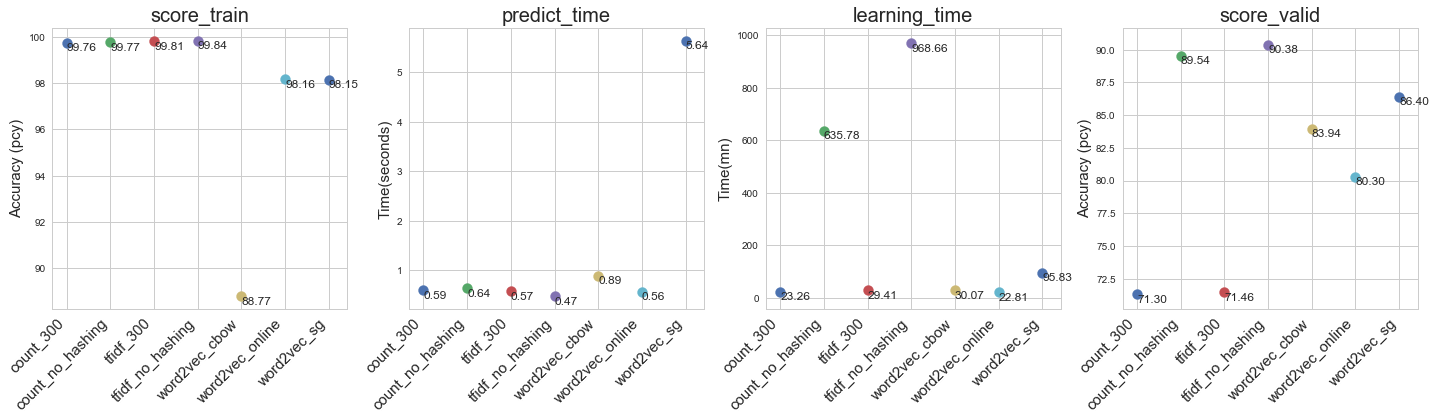

In [12]:
metadata_list_mlp = pickle.load(open("data/metadata_mlp_part13.pkl","rb"))       
metadata_list_mlp_sorted = sorted(metadata_list_mlp, key = lambda x : x["name"])
xlabelticks = [metadata["name"] for metadata in metadata_list_mlp_sorted]

fig = plt.figure(figsize=(20,6))
key_plot = [key for key in metadata_list_mlp[0].keys() if key !="name"]
for iplot, key in enumerate(key_plot):
    ax = fig.add_subplot(1,4,iplot+1)
    for i,metadata in enumerate(metadata_list_mlp_sorted):
        if key=="learning_time":
            scale=60
            ylabel="Time(mn)"
        elif key=="predict_time":
            scale=1
            ylabel="Time(seconds)"
        else:
            scale=0.01
            ylabel = 'Accuracy (pcy)'
            
        ax.scatter(i,metadata[key]/scale, s=100)
        ax.text(i,metadata[key]/scale,"%.2f"%(metadata[key]/scale), ha="left", va="top")
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(xlabelticks, rotation=45, fontsize=15, ha="right")
    ax.set_title(key, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=15)
plt.tight_layout()
plt.show()

In [13]:
2

2